In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

from nn.training.dataset import *
from nn.training.util import *

window_size = 200
stride = 1

2024-02-04 03:34:44.686207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 03:34:44.686248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 03:34:44.687087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 03:34:44.692626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 03:34:45.328481: W tensorflow/compiler/tf2

In [1]:
models = [
    '6dof',
    '9dof',
]
model_name = models[1]

model = load_model(f'../nn/{model_name}.hdf5')

fn = 'handheld_male_rect'

df = pd.read_csv(f'../capture/{fn}.csv', index_col=[0], header=[0,1]).reset_index(drop=True).drop(columns='Q')
df['accel'] /= 9.80665
# df['accel', 'z'] *= 1
df

NameError: name 'load_model' is not defined

In [51]:
import imufusion

offset = imufusion.Offset(200)
ahrs = imufusion.Ahrs()
ahrs.settings = imufusion.Settings(imufusion.CONVENTION_NED,
                                   5,  # gain
                                   2000,  # gyroscope range
                                   10,  # acceleration rejection
                                   10,  # magnetic rejection
                                   5 * 200 )  # rejection timeout = 5 seconds

def update(x):
    # ahrs.update(x['gyro'].to_numpy(), x['accel'].to_numpy(), x['mag'].to_numpy(), 0.005)
    ahrs.update_no_magnetometer(x['gyro'].to_numpy() * 64, x['accel'].to_numpy(), 0.005)

    euler = ahrs.quaternion.to_euler()
    Q = ahrs.quaternion.wxyz    
    acceleration = ahrs.earth_acceleration  # convert g to m/s/
    
    ans = {}
    ans.update({'x': acceleration[0], 'y':acceleration[1], 'z':acceleration[2]})
    ans.update({'roll': euler[0], 'pitch' : euler[1], 'yaw' : euler[2]})
    ans.update({'Q_T' : Q})
    ans.update({"accel_err" : ahrs.internal_states.acceleration_error})
    ans.update({"accel_igr" : ahrs.internal_states.accelerometer_ignored})
    ans.update({"accel_rec" : ahrs.internal_states.acceleration_recovery_trigger})
    
    ans.update({"ang_rrec" : ahrs.flags.angular_rate_recovery})
    ans.update({"accel_rrec" : ahrs.flags.acceleration_recovery})
    return ans

q = df.apply(update, axis=1)
q = pd.DataFrame(list(q))

sf = df['accel']
# df['accel'] = q[['x', 'y', 'z']]
# g = np.linalg.norm(df['accel'], axis=1)[:100].mean()
# df['accel', 'z'] += g
# df['accel'] /= g

9/9 [==============================] - 2s 45ms/step


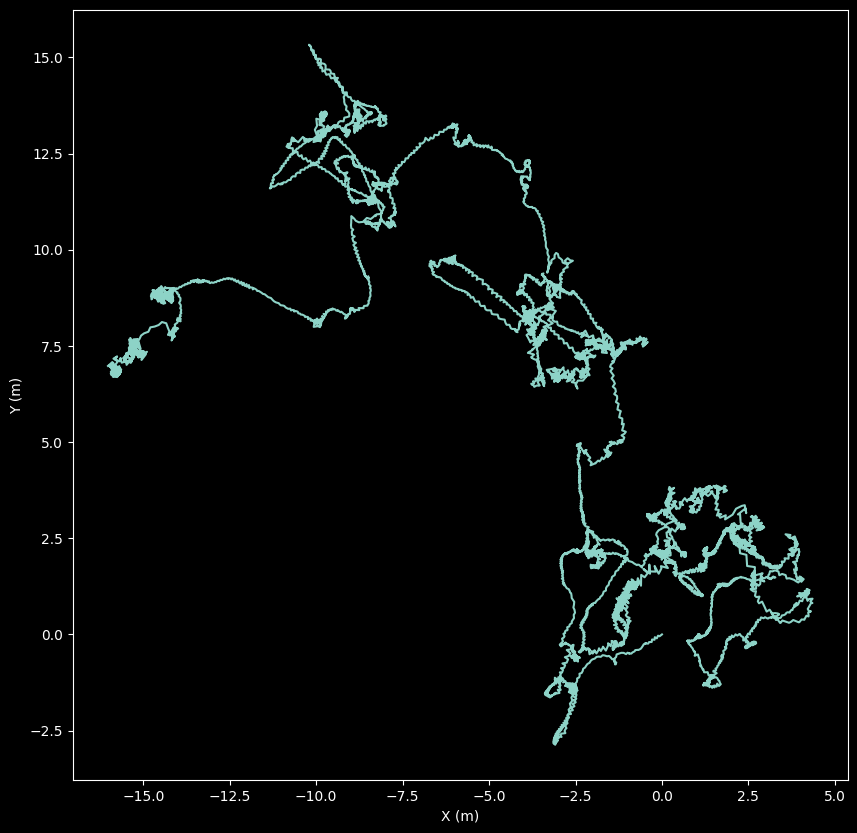

In [52]:
x_gyro, x_accel, x_mag = load_dataset_6d(df['gyro'].to_numpy(), sf.to_numpy(), df['mag'].to_numpy(), window_size, stride)

if model_name == models[2]:
    [yhat_delta_p, yhat_delta_q] = model.predict([x_gyro[: , :, :], x_accel[:, :, :], x_mag[:, :, :]], batch_size=1024, verbose=1)
else:
    [yhat_delta_p, yhat_delta_q] = model.predict([x_gyro[: , :, :], x_accel[:, :, :]], batch_size=1024, verbose=1)
    
trajectory = generate_trajectory_6d_quat([0,0,0], q['Q_T'][100], yhat_delta_p, yhat_delta_q)

fig, ax = plt.subplots(1, figsize=(10, 10))#, subplot_kw={'projection': '3d'})
ax.plot(trajectory[:, 0], trajectory[:, 1])#, pred_trajectory[:, 2])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.show()